In [1]:
#Import libraries
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import time

#Load signal file
sig_file = uproot.open("user.calpert.mc16_13TeV.311423.MGPy8EG_A14NNPDF23_NNPDF31ME_HSS_LLP_mH600_mS150_lthigh.032123_trees.root/user.calpert.311423.e7357_e5984_s3234_r10201_r10210_p4696.32829947._000001.trees.root:trees_DV_")

In [280]:
#Define helper functions
def dp(branch):
    for i, value in enumerate(branch):
        print("Value:", branch[i], "   Index:",i) #Display all elements

def dp10(branch):
    for i, value in enumerate(branch[0:10]):
        print("Value:", branch[i], "   Index:",i) #Display first 10 elements
        
def dp100(branch):
    for i, value in enumerate(branch[0:100]):
        print("Value:", branch[i], "   Index:",i) #Display first 100 elements
        
def dp1000(branch):
    for i, value in enumerate(branch[0:1000]):
        print("Value:", branch[i], "   Index:",i) #Display all elements

        
def ratio(branch):
    ratio = ak.count_nonzero(branch)/ak.count(branch)
    print(ratio) #Display ratio of number of elements that pass

In [6]:
#Import relevant branches
mdt = sig_file["MSVtx_nMDT"].array()#(entry_stop = 10)
rpc = sig_file["MSVtx_nRPC"].array()#(entry_stop = 10)
tgc = sig_file["MSVtx_nTGC"].array()#(entry_stop = 10)
eta = sig_file["MSVtx_eta"].array()#(entry_stop = 10)
ntrks = sig_file['MSVtx_nTrks'].array()

### MDT/TGC/RPC Hits

In [7]:
#Flatten arrays
MDT_flat =ak.flatten(sig_file["MSVtx_nMDT"].array())
RPC_flat = ak.flatten(sig_file["MSVtx_nRPC"].array())
TGC_flat = ak.flatten(sig_file["MSVtx_nTGC"].array())

<Figure size 432x288 with 0 Axes>

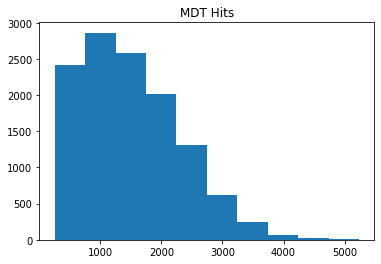

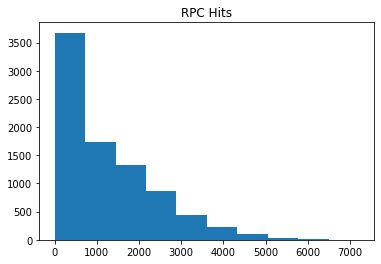

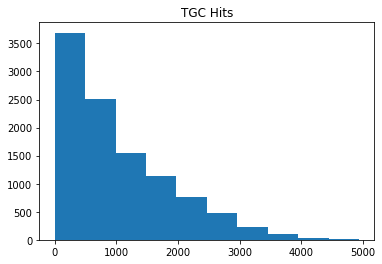

<Figure size 432x288 with 0 Axes>

In [8]:
#Plot a histogram of hits from all three sources. Include only nonnegative values
plt.hist(MDT_flat[MDT_flat>0], label = "MDT hits")
plt.title("MDT Hits")
plt.figure()
plt.hist(RPC_flat[RPC_flat>0], label = "RPC hits")
plt.title("RPC Hits")
plt.figure()
plt.hist(TGC_flat[TGC_flat>0], label = "TGC hits")
plt.title("TGC Hits")
plt.figure()

#### Barrel and Endcap cuts for MDT/TGC/RPC hits

In [9]:
#CUT FOR MDT AND RPC HITS IN BARREL
hits_barrel_cut= ((mdt > 300) & (mdt < 3000))\
& ((rpc > 250) & (abs(eta) <= 1.0))

In [10]:
#CUT FOR MDT AND TGC HITS IN THE ENDCAP
hits_endcap_cut= ((mdt > 300) & (mdt < 3000))\
& ((tgc > 250) & ((abs(eta) > 1.0) & (abs(eta) < 2.5)))

In [276]:
#Check pct of hits that pass
ratio(hits_barrel_cut)

0.07698333431251592


In [277]:
#Check pct of hits that pass
ratio(hits_endcap_cut)

0.13555803615142079


### Filter events with minimum number of tracklets

In [14]:
#Discard erroneous values
good_trks = ntrks[ntrks > 0]

Text(0.5, 1.0, '# of tracks per vertex')

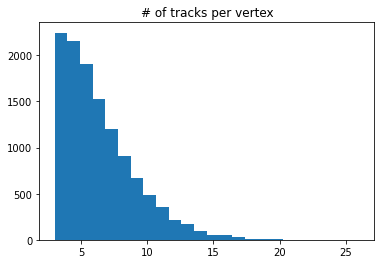

In [15]:
#Plot number of tracks per vertex
plt.hist(ak.flatten(good_trks), bins = (ak.max(ntrks)-2), label = "#number of track per vertex")
plt.title("# of tracks per vertex")

In [167]:
#Will need to check # of tracks per vertex. Make sure there are 3(4) in barrel(endcap)
ntrks_barrel = ntrks >=3
ntrks_endcap = ntrks >=4

In [168]:
#Calculate pct of events with ntrks > 3
pct(ntrks_barrel)

0.23762802812212366


In [169]:
#Calculate pct of events with ntrks > 4
pct(ntrks_endcap)

0.1936431467011339


#### Veto Region Cut

In [170]:
#CUT FOR VETO REGION
veto_cut = (0.7 < eta) & (1.3 > eta)

In [171]:
#Calculate pct of verticies that pass veto region
pct(veto_cut)

0.0368564322503574


### Final selection for good MS Vertices

In [22]:
goodMSvert_barrel = veto_cut & hits_barrel_cut & ntrks_barrel
goodMSvert_endcap = veto_cut & hits_endcap_cut & ntrks_endcap

In [23]:
#Calculate percent of vertices in barrel that make final cut
pct(goodMSvert_barrel)

0.015059828055539235


In [24]:
#Calculate percent of vertices in endcap that make final cut
pct(goodMSvert_endcap)

0.01225936588136224


In [25]:
#Calc # of good verticies in barrel
ak.count_nonzero(goodMSvert_barrel)

769

In [26]:
#Calc # of good verticies in endcap
ak.count_nonzero(goodMSvert_endcap)

626

### We have 769 good vertices in barrel and 626 good vertices in endcap. Now apply preselection, then perform isolation requirements on any leftover events

## Preselection

In [175]:
#Keep verticies with a multiplicity of at least 2
multiplicity = ak.num(eta) >=2
#print # of events with multiplicity > 1
ak.count_nonzero(multiplicity)

1014

In [55]:
#Add trigger and goodPV
trig = sig_file["pass_HLT_j30_muvtx_noiso"].array()
goodPV = sig_file["hasGoodPV"].array()

In [178]:
#Take preselection
preselection = (trig == True) & (goodPV == True) & (multiplicity == True)

In [179]:
#How many events pass preselection?
ak.count_nonzero(preselection)

669

### 669 events pass preselection

In [184]:
barrel_pass = goodMSvert_barrel & preselection
endcap_pass = goodMSvert_endcap & preselection

In [183]:
ak.count_nonzero(barrel_pass)

105

In [185]:
ak.count_nonzero(endcap_pass)

99

### We have 105 events in barrel and 99 in endcap that contain good vertices and pass preselection before isolation

## Now time to eliminate vertices from punch through jets

In [27]:
#Do I need these????? Would eliminate events significantly
trig400 = sig_file['pass_HLT_j400'].array()
trig420 = sig_file['pass_HLT_j420'].array()

### Jet Isolation

In [196]:
#Calculate jet cutflow first
#Load necessary branches
jet_pT=sig_file['jet_pT'].array()
jet_logRatio=sig_file['jet_logRatio'].array() 
jet_JVT=sig_file['jet_jvt'].array() 
jet_eta=sig_file['jet_eta'].array() 
jet_phi=sig_file['jet_phi'].array() 

#Cutflow on jets
jet_cut = (jet_pT > 30) & (jet_logRatio < 0.5) & (((jet_JVT > 0.59) & (jet_pT < 60)) | ((jet_JVT == True) & (jet_pT >= 60)))
good_jets = ak.count_nonzero(jet_cut, axis =1)

In [281]:
#Take a look at first 10 of good_jets
dp10(good_jets)

Value: 0    Index: 0
Value: 1    Index: 1
Value: 1    Index: 2
Value: 0    Index: 3
Value: 2    Index: 4
Value: 0    Index: 5
Value: 1    Index: 6
Value: 1    Index: 7
Value: 0    Index: 8
Value: 0    Index: 9


In [197]:
jet_eta_pairs = ak.combinations(jet_eta, n=2, fields = ["x","y"])
jet_delta_eta=abs(jet_eta_pairs["y"] - jet_eta_pairs["x"])

In [198]:
jet_phi_pairs = ak.combinations(jet_phi, n=2, fields = ["x","y"])
jet_delta_phi=abs(jet_phi_pairs["y"] - jet_phi_pairs["x"])

In [199]:
jet_eta_sq = jet_delta_eta * jet_delta_eta
jet_phi_sq = jet_delta_phi * jet_delta_phi

In [200]:
jet_delta = jet_eta_sq + jet_phi_sq

In [206]:
#Check if any value of jet_delta < 0.09 (barrel) and 0.36 (endcap)
print(ak.any(jet_delta < 0.09))
print(ak.any(jet_delta < 0.36))

False
True


#### We have some punch through jets in the endcap so need to check if these correspond with any good verticies

In [243]:
#Create a cut with jet_delta > 0.36. This will help us create an appropriate boolean array to compare with good MS vert
jet_delta_cut_endcap = jet_delta < 0.36
jet_delta_cut_barrel = jet_delta < 0.09

In [244]:
jet_bool_endcap = ak.any(jet_delta_cut_endcap, axis =1)
jet_bool_barrel = ak.any(jet_delta_cut_barrel, axis =1)

In [282]:
#Take a look at first 10 in endcap
dp10(jet_bool_endcap)

Value: False    Index: 0
Value: True    Index: 1
Value: False    Index: 2
Value: True    Index: 3
Value: True    Index: 4
Value: False    Index: 5
Value: False    Index: 6
Value: True    Index: 7
Value: True    Index: 8
Value: True    Index: 9


In [283]:
#Take a look at first 10 in barrel. We expect all false
dp10(jet_bool_barrel)

Value: False    Index: 0
Value: False    Index: 1
Value: False    Index: 2
Value: False    Index: 3
Value: False    Index: 4
Value: False    Index: 5
Value: False    Index: 6
Value: False    Index: 7
Value: False    Index: 8
Value: False    Index: 9


In [ ]:
#Now apply sum_pT cut
#cut abs(sum(track pT))...removes erroneous values of -1e+05 as well
log_ratio_cut = (jet_logRatio > -1e+05) & (abs(jet_logRatio) < 10 )
log_ratio_bool = ak.any(log_ratio_cut, axis =1)

In [220]:
#Now apply our jet_bool with endcap_pass

In [273]:
true_endcap = endcap_pass & (jet_bool_endcap == False) & log_ratio_bool
true_barrel = barrel_pass & (jet_bool_barrel == False) & log_ratio_bool

In [274]:
ak.count_nonzero(true_barrel)

105

In [275]:
ak.count_nonzero(true_endcap)

40

### Our number of good vertices in the endcap decreased from 99 to 40

### We still need to account for track isolation then we are finished